In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [2]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
sys.path.append(os.getcwd()+"/../../")

import pickle
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from ood_detection_helper import *

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
sns.set(style="darkgrid")

seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.experimental.list_physical_devices('GPU'))
tf.__version__

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


'2.3.1'

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Loading OOD datasets

In [4]:
with open("train_scores.p", "rb") as f:
    train_scores = pickle.load(f)
train_scores.shape

(50000, 10)

In [5]:
with open("scores.p", "rb") as f:
    score_dict = pickle.load(f)
score_dict.keys()

dict_keys(['cifar', 'celeba', 'svhn'])

In [6]:
inlier_scores = score_dict["cifar"]
outlier_scores = [score_dict["svhn"]]

In [7]:
with open("ood_scores.p", "rb") as f:
    ood_dict = pickle.load(f)
outlier_scores.extend([x for x in ood_dict.values()])

In [8]:
non_synthetic_images = ['LSUN','LSUN_resize', 'Imagenet', 'Imagenet_resize', 'iSUN']
outlier_scores.append(np.concatenate([ood_dict[n].numpy() for n in non_synthetic_images]))

In [9]:
ood_names = list(score_dict.keys())[1:] + list(ood_dict.keys()) + ["All Images"]
ood_names, len(outlier_scores)

(['celeba',
  'svhn',
  'LSUN',
  'LSUN_resize',
  'Imagenet',
  'Imagenet_resize',
  'iSUN',
  'gaussian',
  'uniform',
  'All Images'],
 9)

In [10]:
LABELS = np.array(["Train", "CIFAR", "SVHN", 'LSUN_crop','LSUN_resize',
                   'Imagenet_crop','Imagenet_resize','iSUN',"Gaussian", "Uniform", "All Images"])
COLORS = sns.color_palette("bright")

## Separation for *Lowest* Sigma i.e. "Truest" Score

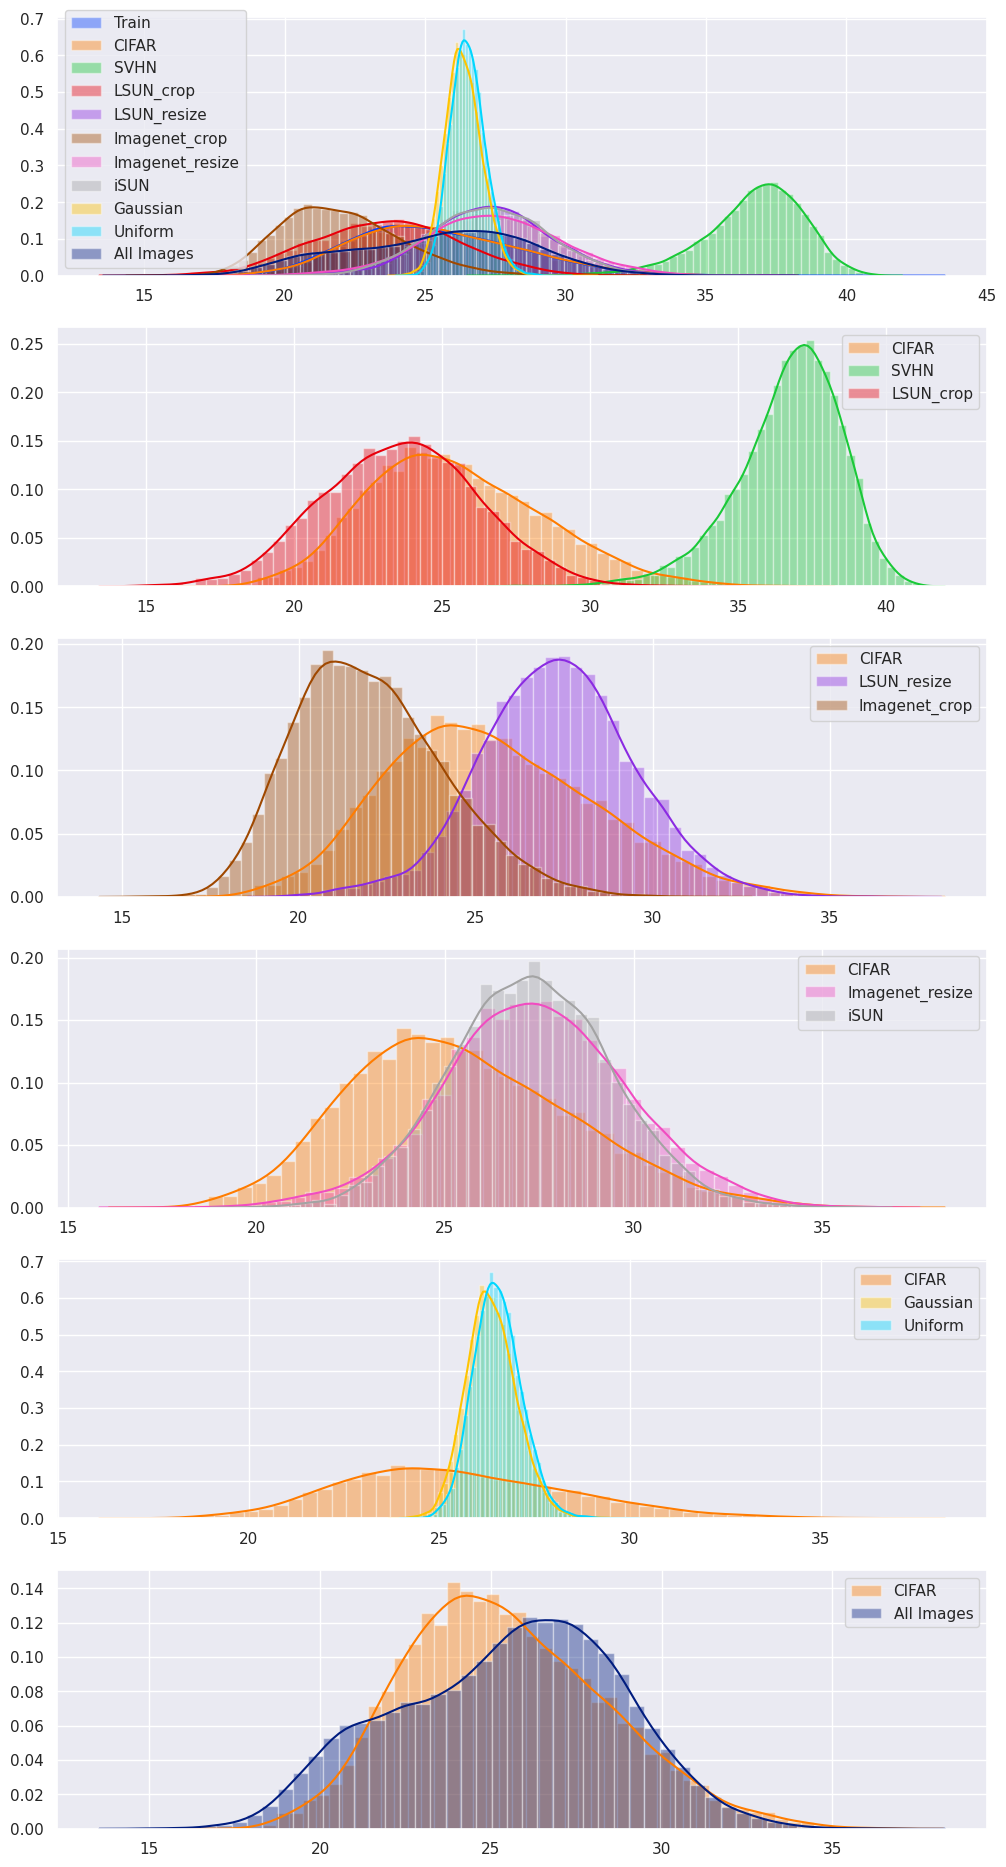

In [11]:
cifar_score = inlier_scores[:, -1]
ood_scores = [ood[:,-1] for ood in outlier_scores]

evaluate_model(train_scores[:,-1], cifar_score, ood_scores, labels=LABELS)

# Auxiliary model analysis

In [12]:
# Train Data = L2-norm(Pixel Scores)
X_train, X_test =  train_scores.copy(), inlier_scores.copy()

========================= Training GMM =========================
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   20.7s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  3.0min finished


Best: 2.536454 using {'GMM__covariance_type': 'full', 'GMM__n_components': 20}
---------------------------------------------------------------------------
2.104516 (0.049782) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
2.345415 (0.048733) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
2.430823 (0.045406) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 6}
2.456722 (0.047405) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 8}
2.486704 (0.040669) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 10}
2.507592 (0.046426) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 12}
2.522635 (0.043442) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 14}
2.529186 (0.043199) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 16}
2.535364 (0.045171) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 18}
2.536454 (0.043099) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 20}


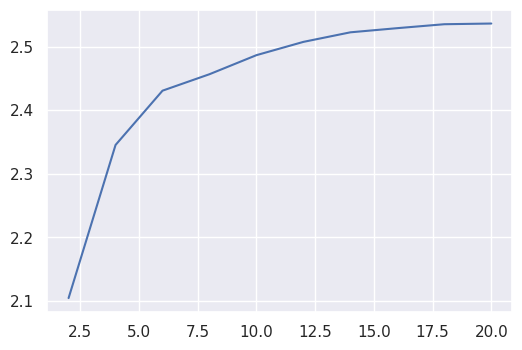

---Likelihoods---
Training: 2.571
CIFAR: 2.427
SVHN: -4.146
LSUN_crop: -1104.889
LSUN_resize: -598.525
Imagenet_crop: -636.827
Imagenet_resize: -784.712
iSUN: -647.582
Gaussian: -397.058
Uniform: -362.290
All Images: -756.856
========================= Training Flow Model =========================
Epoch 1/1000
390/390 [==============================] - 1s 3ms/step - loss: 13294.1885 - val_loss: 5945.9863
Epoch 2/1000
390/390 [==============================] - 1s 3ms/step - loss: 3491.7988 - val_loss: 1980.7638
Epoch 3/1000
390/390 [==============================] - 1s 3ms/step - loss: 1368.7838 - val_loss: 979.8855
Epoch 4/1000
390/390 [==============================] - 1s 2ms/step - loss: 798.8320 - val_loss: 673.3580
Epoch 5/1000
390/390 [==============================] - 1s 2ms/step - loss: 602.6506 - val_loss: 551.5464
Epoch 6/1000
390/390 [==============================] - 1s 2ms/step - loss: 519.1431 - val_loss: 494.8544
Epoch 7/1000
390/390 [==============================] - 1s 3

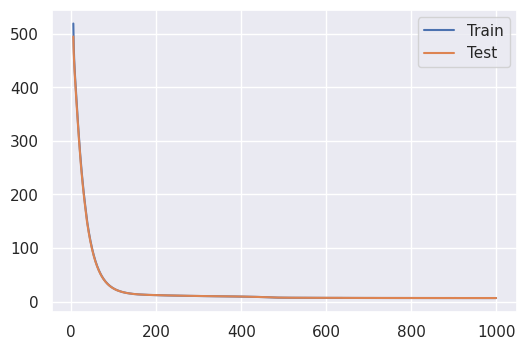

========================= Training KD Tree =========================
CPU times: user 42min 57s, sys: 20min 24s, total: 1h 3min 21s
Wall time: 20min 49s


In [13]:
%%time
results = auxiliary_model_analysis(X_train, X_test, outlier_scores, LABELS, flow_epochs=1000)

In [35]:
TEST_IDX=0

## GMM

In [14]:
results["GMM"]["metrics"]

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
SVHN,10.56,7.670000,95.896356,92.512453,97.113888,5.86,92.520523
LSUN_crop,0.00,0.020000,99.999856,99.999857,99.999856,0.00,99.999857
LSUN_resize,0.00,0.045000,99.999583,99.999589,99.999580,0.00,99.999589
Imagenet_crop,0.00,0.040000,99.999924,99.999924,99.999924,0.00,99.999924
Imagenet_resize,0.00,0.020000,99.999973,99.999973,99.999973,0.00,99.999973
iSUN,0.00,0.026204,99.999468,99.999427,99.999516,0.00,99.999427
Gaussian,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
Uniform,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
All Images,0.00,0.033396,99.999767,99.999953,99.998850,0.00,99.999953


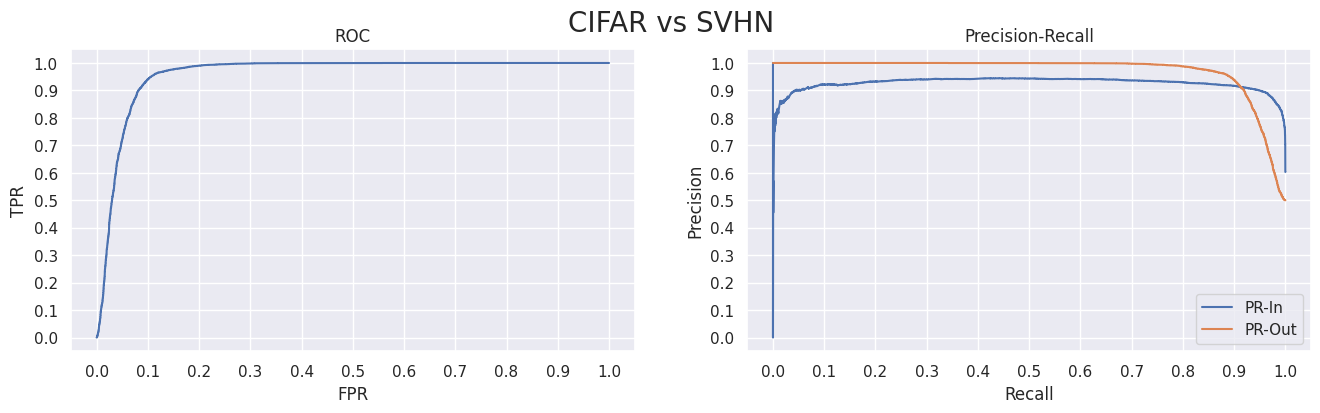

CIFAR vs SVHN
----------------
ROC-AUC: 95.8964
PR-AUC (In/Out): 92.5125 / 97.1139
FPR (95% TPR): 10.56%
Detection Error: 7.67%


{'fpr_tpr95': 0.1056,
 'de': 0.07670000000000002,
 'roc_auc': 0.9589635600000002,
 'pr_auc_in': 0.9251245314057921,
 'pr_auc_out': 0.9711388846390376,
 'fpr_tpr80': 0.0586,
 'ap': 0.9252052261784804}

In [36]:
ood_metrics(-results["GMM"]["test_scores"], -results["GMM"]["ood_scores"][TEST_IDX],
            names=(LABELS[1], LABELS[TEST_IDX+2]), plot=True, verbose=True)

### Validation Check

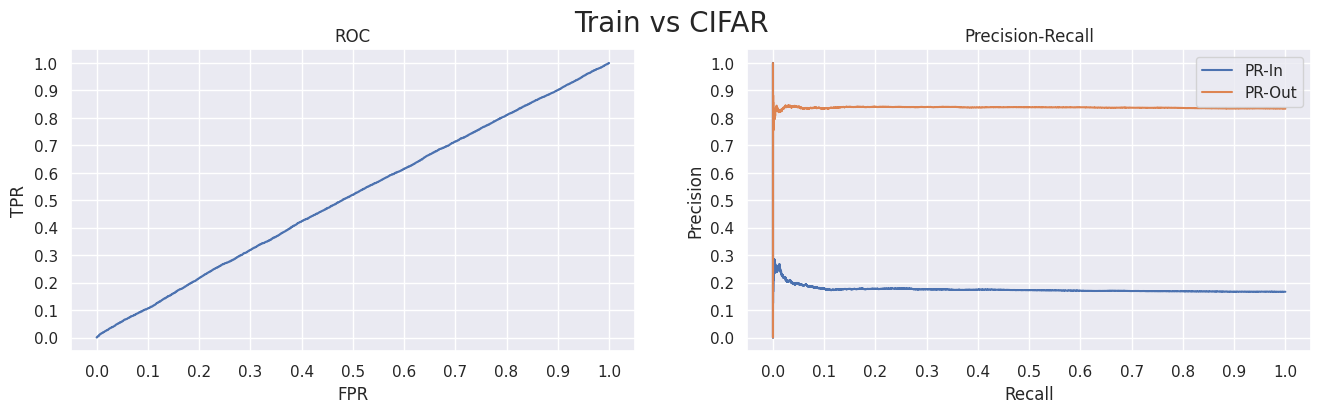

Train vs CIFAR
----------------
ROC-AUC: 51.2901
PR-AUC (In/Out): 17.4958 / 83.7408
FPR (95% TPR): 94.77%
Detection Error: 48.79%


{'fpr_tpr95': 0.94772,
 'de': 0.48793,
 'roc_auc': 0.512900676,
 'pr_auc_in': 0.17495800013882337,
 'pr_auc_out': 0.8374078891750855,
 'fpr_tpr80': 0.7799,
 'ap': 0.1750507414624996}

In [16]:
ood_metrics(-results["GMM"]["train_scores"], -results["GMM"]["test_scores"], names=(LABELS[0], LABELS[1]), plot=True, verbose=True)

## Flow Models

In [37]:
results["Flow"]["metrics"]

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
SVHN,8.84,6.830000,96.427928,92.247116,97.584910,4.74,92.256234
LSUN_crop,0.00,0.035000,99.999705,99.999709,99.999703,0.00,99.999709
LSUN_resize,0.00,0.045000,99.999707,99.999709,99.999706,0.00,99.999709
Imagenet_crop,0.00,0.030000,99.999924,99.999924,99.999924,0.00,99.999924
Imagenet_resize,0.00,0.015000,99.999975,99.999975,99.999975,0.00,99.999975
iSUN,0.00,0.037409,99.999339,99.999295,99.999396,0.00,99.999295
Gaussian,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
Uniform,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
All Images,0.00,0.033396,99.999739,99.999947,99.998706,0.00,99.999947


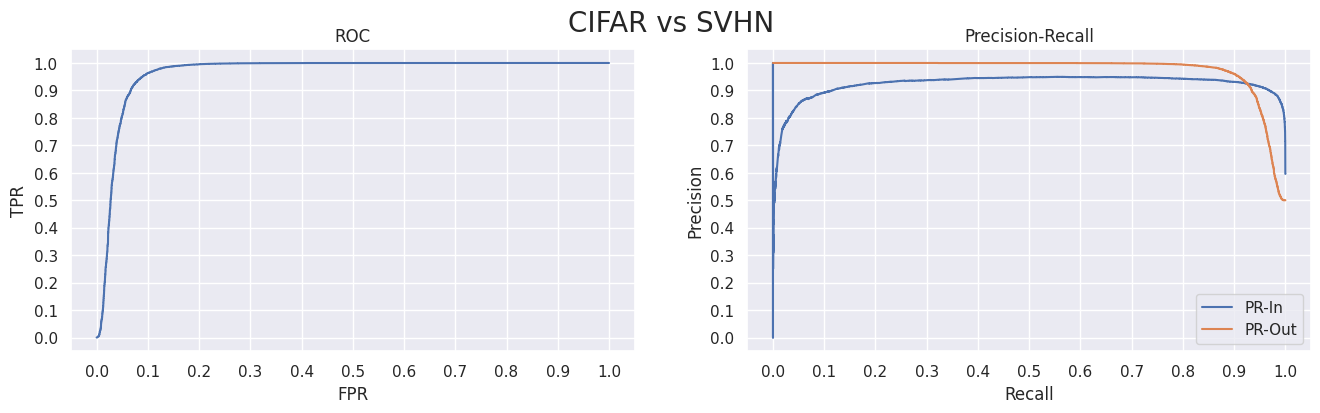

CIFAR vs SVHN
----------------
ROC-AUC: 96.4279
PR-AUC (In/Out): 92.2471 / 97.5849
FPR (95% TPR): 8.84%
Detection Error: 6.83%


{'fpr_tpr95': 0.0884,
 'de': 0.06829999999999997,
 'roc_auc': 0.9642792800000001,
 'pr_auc_in': 0.9224711578908321,
 'pr_auc_out': 0.9758490996632196,
 'fpr_tpr80': 0.0474,
 'ap': 0.9225623364688116}

In [38]:
ood_metrics(-results["Flow"]["test_scores"], -results["Flow"]["ood_scores"][TEST_IDX],
            names=(LABELS[1], LABELS[TEST_IDX+2]), plot=True, verbose=True)

### Validation Check

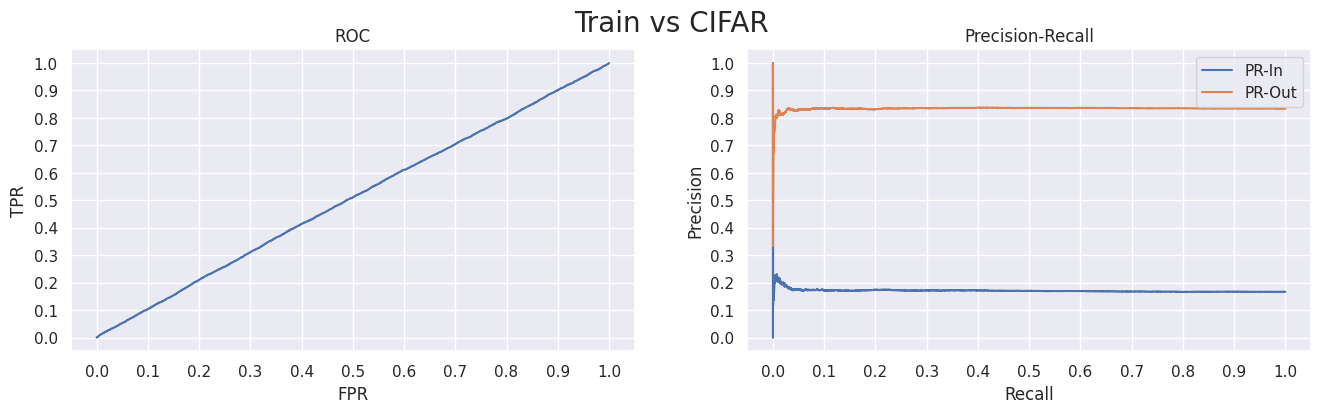

Train vs CIFAR
----------------
ROC-AUC: 50.6100
PR-AUC (In/Out): 17.0486 / 83.3963
FPR (95% TPR): 95.07%
Detection Error: 49.24%


{'fpr_tpr95': 0.9507,
 'de': 0.49239,
 'roc_auc': 0.506100305,
 'pr_auc_in': 0.17048605255714627,
 'pr_auc_out': 0.8339634932087855,
 'fpr_tpr80': 0.79204,
 'ap': 0.17056272532944775}

In [19]:
ood_metrics(-results["Flow"]["train_scores"], -results["Flow"]["test_scores"], names=(LABELS[0], LABELS[1]), plot=True, verbose=True)

## KD Trees w/ k=5

In [39]:
results["KD"]["metrics"]

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
SVHN,4.11,4.480000,99.148397,99.069617,99.208808,0.65,99.069714
LSUN_crop,0.23,0.860000,99.946453,99.942667,99.950955,0.03,99.942670
LSUN_resize,0.57,1.450000,99.858522,99.838443,99.874196,0.11,99.838454
Imagenet_crop,0.51,1.405000,99.864705,99.843345,99.881427,0.11,99.843356
Imagenet_resize,0.25,0.990000,99.933930,99.926449,99.940817,0.03,99.926454
iSUN,0.39,1.249804,99.892598,99.862438,99.914401,0.06,99.862448
Gaussian,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
Uniform,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
All Images,0.38,1.218327,99.899388,99.976755,99.656194,0.05,99.976755


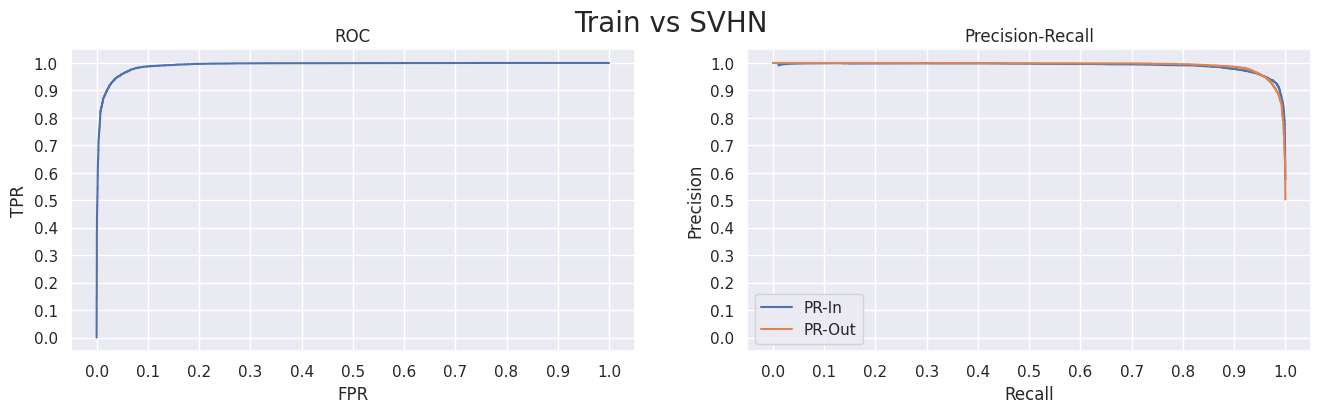

Train vs SVHN
----------------
ROC-AUC: 99.1484
PR-AUC (In/Out): 99.0696 / 99.2088
FPR (95% TPR): 4.11%
Detection Error: 4.48%


{'fpr_tpr95': 0.0411,
 'de': 0.044800000000000006,
 'roc_auc': 0.9914839700000001,
 'pr_auc_in': 0.9906961651441349,
 'pr_auc_out': 0.9920880827440841,
 'fpr_tpr80': 0.0065,
 'ap': 0.9906971353462364}

In [40]:
ood_metrics(results["KD"]["test_scores"], results["KD"]["ood_scores"][TEST_IDX],
            names=(LABELS[TEST_IDX], LABELS[TEST_IDX+2]), plot=True, verbose=True)

### Validation Check

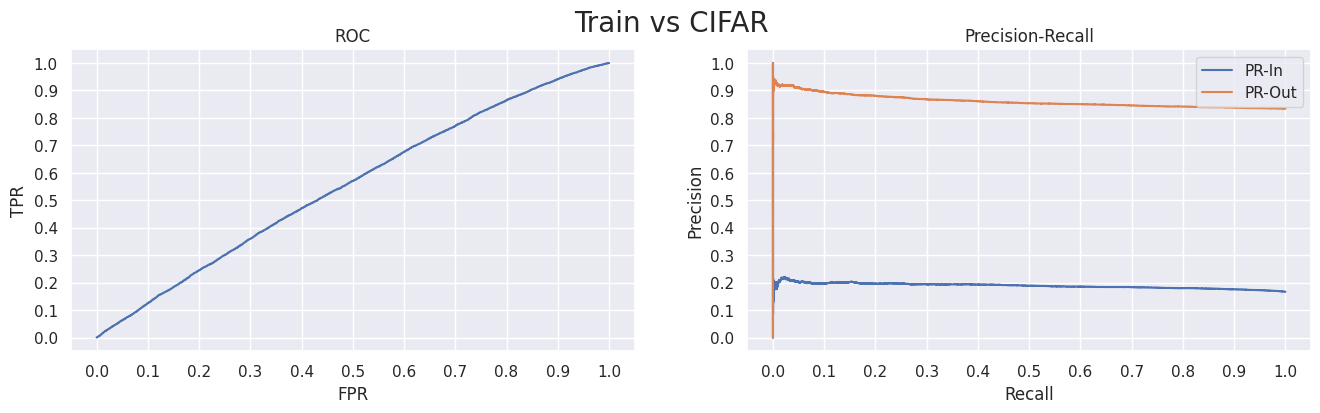

Train vs CIFAR
----------------
ROC-AUC: 55.2840
PR-AUC (In/Out): 18.8324 / 86.0710
FPR (95% TPR): 91.09%
Detection Error: 46.07%


{'fpr_tpr95': 0.91088,
 'de': 0.46065999999999996,
 'roc_auc': 0.552839922,
 'pr_auc_in': 0.18832372951924875,
 'pr_auc_out': 0.8607102295805986,
 'fpr_tpr80': 0.72198,
 'ap': 0.18840465215808516}

In [22]:
ood_metrics(results["KD"]["train_scores"], results["KD"]["test_scores"], names=(LABELS[0], LABELS[1]), plot=True, verbose=True)

## GMM vs Flow vs K-NN Tree on CIFAR vs All (including SVHN and synthetic)

CIFAR vs All
----------------
ROC-AUC: 99.9998
PR-AUC (In/Out): 100.0000 / 99.9988
FPR (95% TPR): 0.00%
Detection Error: 0.03%
CIFAR vs All
----------------
ROC-AUC: 99.9998
PR-AUC (In/Out): 100.0000 / 99.9987
FPR (95% TPR): 0.00%
Detection Error: 0.03%
CIFAR vs All
----------------
ROC-AUC: 99.9286
PR-AUC (In/Out): 99.9889 / 99.6562
FPR (95% TPR): 0.31%
Detection Error: 1.04%


Text(0.5, 0.98, 'Comparing Auxiliary Methods')

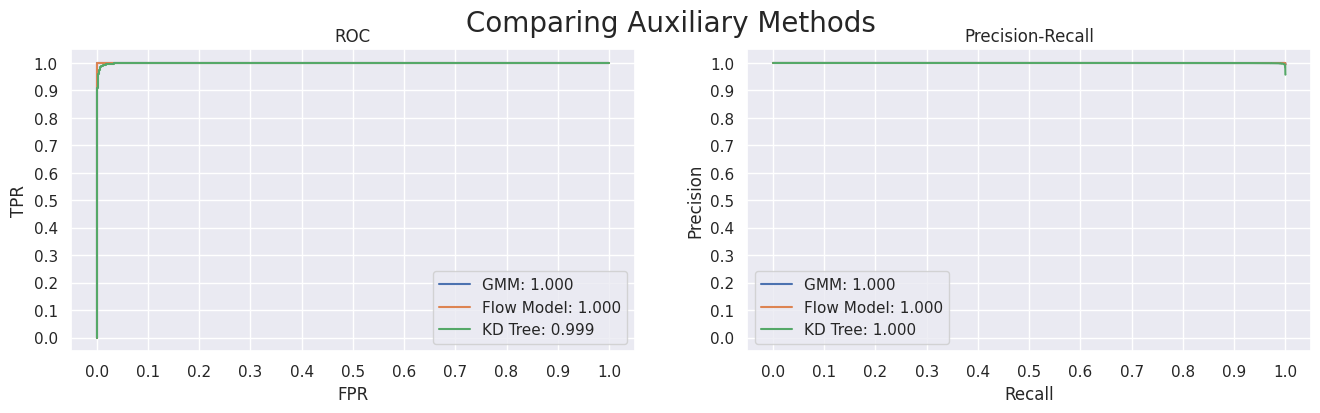

In [23]:
gmm_all = np.concatenate(-results["GMM"]["ood_scores"][1:-1])
flow_all = np.concatenate(-results["Flow"]["ood_scores"][1:-1])
kd_all = np.concatenate(results["KD"]["ood_scores"][1:-1])

pairs = zip(
    ["GMM", "Flow Model", "KD Tree"],
    [-results["GMM"]["test_scores"], -results["Flow"]["test_scores"], results["KD"]["test_scores"]],
    [gmm_all, flow_all, kd_all]
)

fig, axs = plt.subplots(1,2, figsize=(16,4))

for title, cifar_scores, svhn_scores in pairs:
    ood_metrics(cifar_scores, svhn_scores, names=("CIFAR", "All"),plot=False, verbose=True)
    plot_curves(cifar_scores, svhn_scores, title, axs)

# for ax in axs:
#     ax.set(ylim=(0.8, 1.01), yticks=np.arange(0.8, 1.01, step=0.05))
# axs[1].set(ylim=(0.8, 1.01))

plt.suptitle("Comparing Auxiliary Methods",  fontsize=20)
# plt.savefig("../../Figures/aux.png", dpi=200)

## Bonus analysis with CIFAR 10.1 as train set

In [24]:
with open("cifar101_scores.p", "rb") as f:
    cifar101_scores = pickle.load(f).numpy()
cifar101_scores.shape

(2000, 10)

========================= Training GMM =========================
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    6.9s finished


Best: 2.194441 using {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
---------------------------------------------------------------------------
2.024849 (0.181287) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
2.194441 (0.176670) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
2.164208 (0.165475) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 6}
2.117493 (0.162405) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 8}
2.047393 (0.169587) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 10}
1.987270 (0.171740) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 12}
1.862247 (0.243190) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 14}
1.800416 (0.234720) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 16}
1.671393 (0.272019) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 18}
1.596151 (0.255562) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 20}


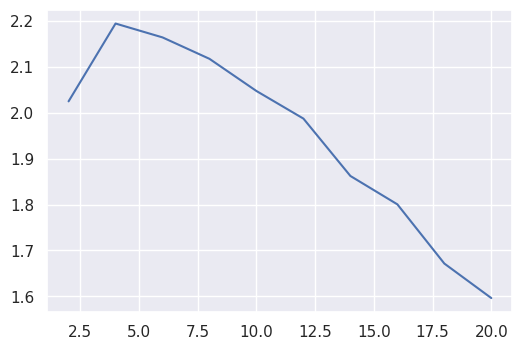

---Likelihoods---
Training: 2.389
CIFAR: 2.189
SVHN: -7.969
LSUN_crop: -1824.531
LSUN_resize: -972.211
Imagenet_crop: -1049.646
Imagenet_resize: -1280.229
iSUN: -1057.816
Gaussian: -1075.318
Uniform: -701.261
All Images: -1240.821
========================= Training Flow Model =========================
Epoch 1/500
15/15 [==============================] - 0s 20ms/step - loss: 8203.5303 - val_loss: 7341.0186
Epoch 2/500
15/15 [==============================] - 0s 9ms/step - loss: 6817.9214 - val_loss: 6310.7290
Epoch 3/500
15/15 [==============================] - 0s 8ms/step - loss: 5971.9980 - val_loss: 5619.8330
Epoch 4/500
15/15 [==============================] - 0s 8ms/step - loss: 5376.2549 - val_loss: 5115.9941
Epoch 5/500
15/15 [==============================] - 0s 9ms/step - loss: 4949.9561 - val_loss: 4723.3193
Epoch 6/500
15/15 [==============================] - 0s 9ms/step - loss: 4567.4893 - val_loss: 4406.2734
Epoch 7/500
15/15 [==============================] - 0s 8ms/step -

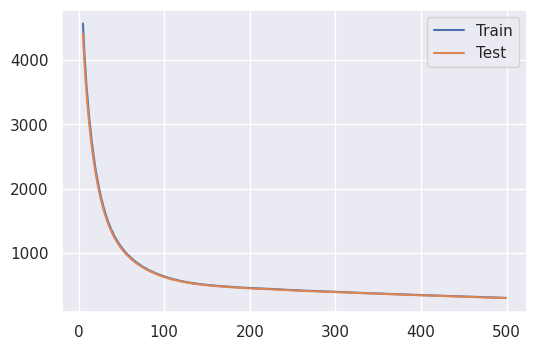

========================= Training KD Tree =========================
CPU times: user 2min 24s, sys: 1min 3s, total: 3min 28s
Wall time: 1min 35s


In [25]:
%%time
results_101 = auxiliary_model_analysis(cifar101_scores, X_test, outlier_scores, LABELS, flow_epochs=500)

## GMM

In [26]:
results_101["GMM"]["metrics"]

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
SVHN,8.03,6.430000,97.519812,95.858385,98.139466,3.38,95.865192
LSUN_crop,0.00,0.035000,99.999747,99.999751,99.999745,0.00,99.999751
LSUN_resize,0.00,0.060000,99.999397,99.999406,99.999393,0.00,99.999406
Imagenet_crop,0.00,0.055000,99.999848,99.999848,99.999848,0.00,99.999848
Imagenet_resize,0.00,0.035000,99.999954,99.999954,99.999954,0.00,99.999954
iSUN,0.00,0.036807,99.999461,99.999419,99.999511,0.00,99.999419
Gaussian,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
Uniform,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
All Images,0.00,0.045549,99.999686,99.999936,99.998452,0.00,99.999936


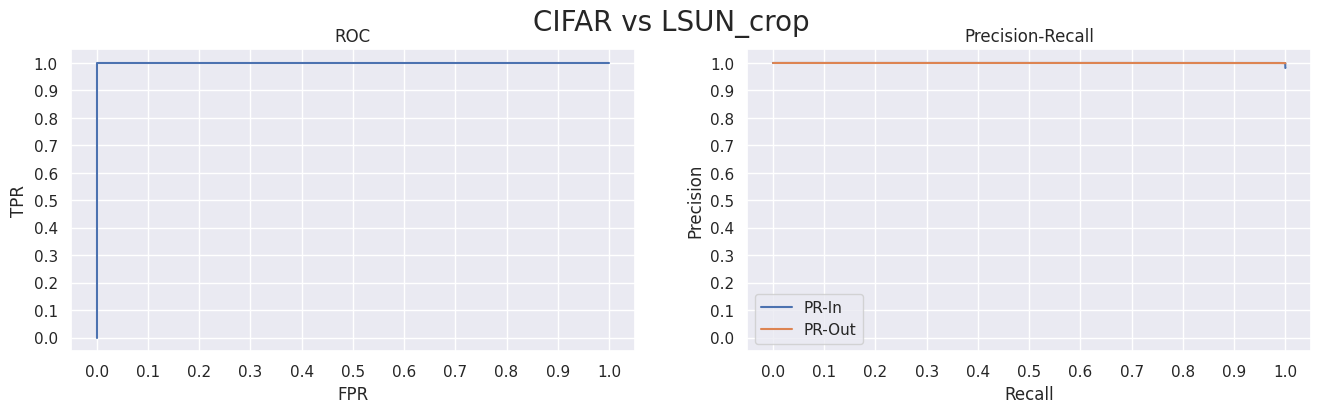

CIFAR vs LSUN_crop
----------------
ROC-AUC: 99.9997
PR-AUC (In/Out): 99.9998 / 99.9997
FPR (95% TPR): 0.00%
Detection Error: 0.03%


{'fpr_tpr95': 0.0,
 'de': 0.00034999999999997793,
 'roc_auc': 0.9999974699999999,
 'pr_auc_in': 0.999997505604185,
 'pr_auc_out': 0.9999974520764878,
 'fpr_tpr80': 0.0,
 'ap': 0.9999975057271562}

In [27]:
ood_metrics(-results_101["GMM"]["test_scores"], -results_101["GMM"]["ood_scores"][1], names=(LABELS[1], LABELS[3]), plot=True, verbose=True)

### Validation Check

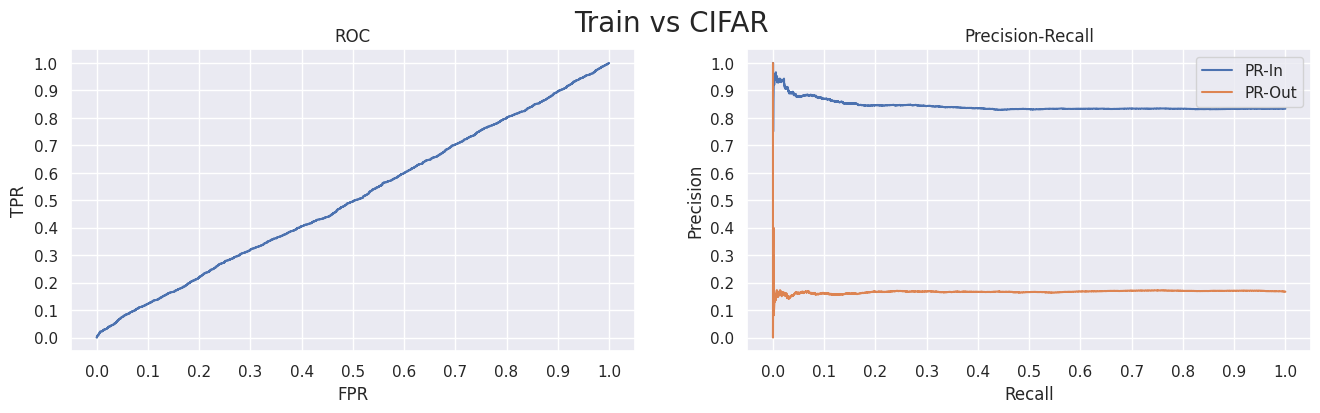

Train vs CIFAR
----------------
ROC-AUC: 50.5910
PR-AUC (In/Out): 84.3150 / 16.6548
FPR (95% TPR): 95.05%
Detection Error: 48.59%


{'fpr_tpr95': 0.9505,
 'de': 0.4859,
 'roc_auc': 0.5059103,
 'pr_auc_in': 0.8431495212659971,
 'pr_auc_out': 0.1665484256956298,
 'fpr_tpr80': 0.791,
 'ap': 0.8431888817553066}

In [28]:
ood_metrics(-results_101["GMM"]["train_scores"], -results_101["GMM"]["test_scores"], names=(LABELS[0], LABELS[1]), plot=True, verbose=True)

## Flow Models

In [29]:
results_101["Flow"]["metrics"]

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
SVHN,99.21,50.000000,20.609076,34.362717,34.635942,95.89,34.366661
LSUN_crop,97.52,49.985000,36.724326,41.377057,41.316990,89.98,41.386249
LSUN_resize,64.98,30.320000,75.219529,69.315468,77.873414,39.95,69.324585
Imagenet_crop,88.34,43.995000,56.417469,52.392179,57.455957,67.55,52.402209
Imagenet_resize,67.69,28.865000,77.454634,74.486042,77.934696,37.36,74.489865
iSUN,71.03,30.992241,74.920739,69.195175,77.576792,41.63,69.200845
Gaussian,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
Uniform,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
All Images,90.80,38.944589,63.910622,88.823408,24.163364,62.65,88.823893


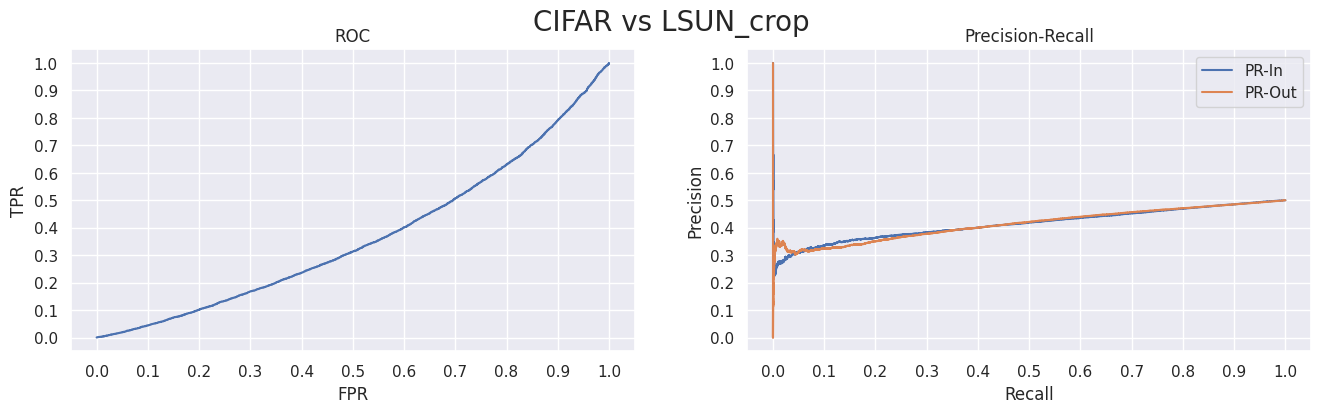

CIFAR vs LSUN_crop
----------------
ROC-AUC: 36.7243
PR-AUC (In/Out): 41.3771 / 41.3170
FPR (95% TPR): 97.52%
Detection Error: 49.98%


{'fpr_tpr95': 0.9752,
 'de': 0.49984999999999996,
 'roc_auc': 0.36724325999999996,
 'pr_auc_in': 0.41377056931934414,
 'pr_auc_out': 0.4131699047520583,
 'fpr_tpr80': 0.8998,
 'ap': 0.4138624894715416}

In [30]:
ood_metrics(-results_101["Flow"]["test_scores"], -results_101["Flow"]["ood_scores"][1], names=(LABELS[1], LABELS[3]), plot=True, verbose=True)

### Validation Check

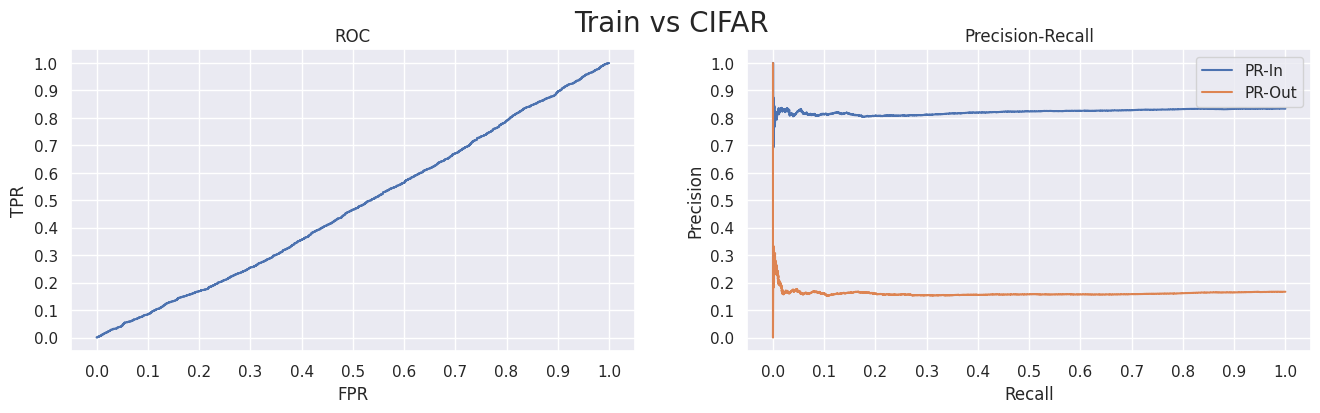

Train vs CIFAR
----------------
ROC-AUC: 47.5452
PR-AUC (In/Out): 82.2392 / 16.0692
FPR (95% TPR): 94.85%
Detection Error: 49.83%


{'fpr_tpr95': 0.9485,
 'de': 0.4983,
 'roc_auc': 0.475452325,
 'pr_auc_in': 0.8223921552971094,
 'pr_auc_out': 0.16069222747033357,
 'fpr_tpr80': 0.802,
 'ap': 0.8224501951680047}

In [31]:
ood_metrics(-results_101["Flow"]["train_scores"], -results_101["Flow"]["test_scores"], names=(LABELS[0], LABELS[1]), plot=True, verbose=True)

## KD Trees w/ k=5

In [32]:
results_101["KD"]["metrics"]

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
SVHN,3.00,3.950000,99.259233,99.216482,99.289315,0.59,99.216538
LSUN_crop,2.83,3.525000,99.276314,99.101767,99.406155,0.91,99.101847
LSUN_resize,5.53,5.195000,98.404026,97.640890,98.750367,1.98,97.643854
Imagenet_crop,4.97,4.770000,98.494348,97.736168,98.845094,1.93,97.737301
Imagenet_resize,3.36,3.645000,99.099587,98.771994,99.286850,1.12,98.772242
iSUN,4.72,4.587787,98.683861,97.871741,99.064132,1.70,97.873196
Gaussian,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
Uniform,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
All Images,4.34,4.423012,98.793995,99.656373,97.057127,1.57,99.656383


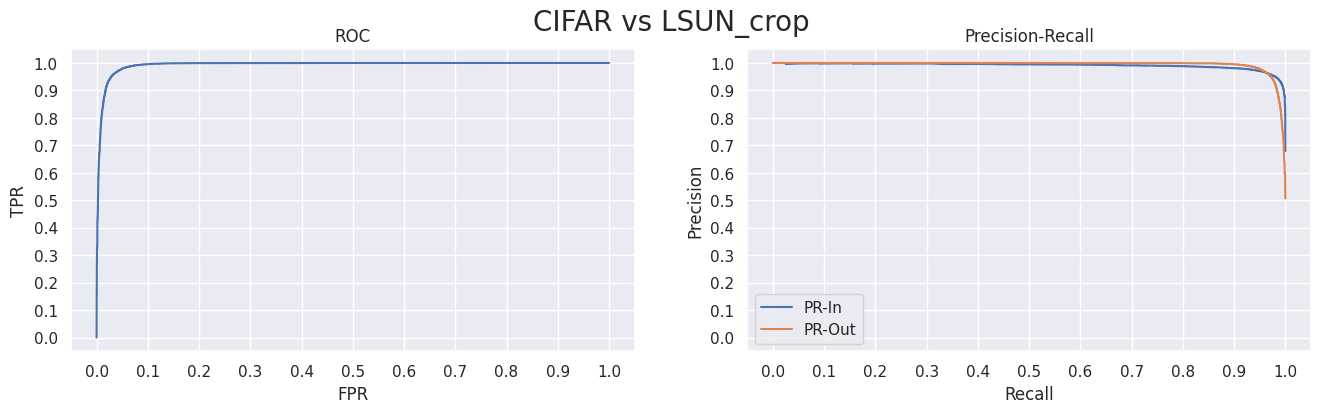

CIFAR vs LSUN_crop
----------------
ROC-AUC: 99.2763
PR-AUC (In/Out): 99.1018 / 99.4062
FPR (95% TPR): 2.83%
Detection Error: 3.52%


{'fpr_tpr95': 0.0283,
 'de': 0.03524999999999998,
 'roc_auc': 0.9927631400000001,
 'pr_auc_in': 0.9910176682102578,
 'pr_auc_out': 0.9940615520037337,
 'fpr_tpr80': 0.0091,
 'ap': 0.9910184738007728}

In [33]:
ood_metrics(results_101["KD"]["test_scores"], results_101["KD"]["ood_scores"][1], names=(LABELS[1], LABELS[3]), plot=True, verbose=True)

### Validation Check

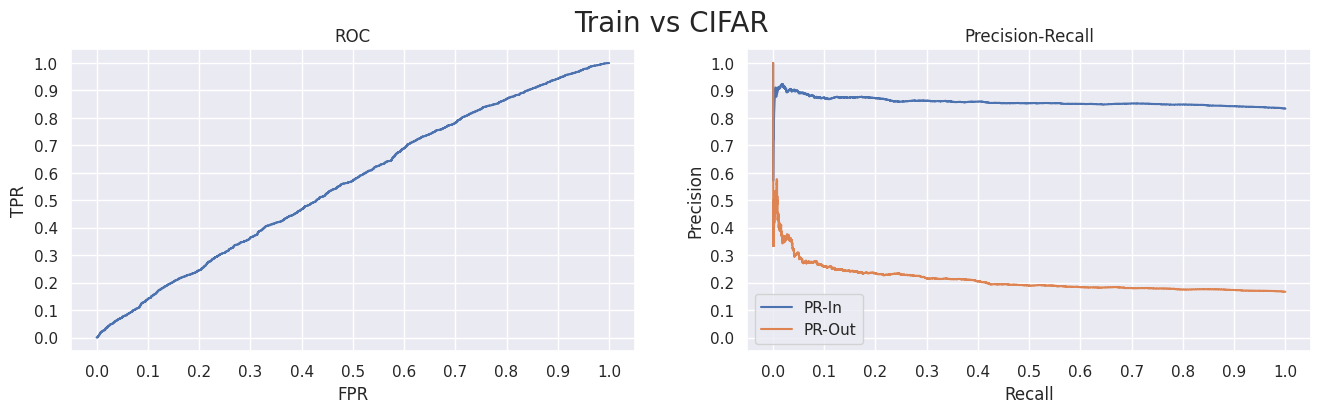

Train vs CIFAR
----------------
ROC-AUC: 55.9905
PR-AUC (In/Out): 85.7844 / 20.9991
FPR (95% TPR): 90.75%
Detection Error: 45.16%


{'fpr_tpr95': 0.9075,
 'de': 0.45165,
 'roc_auc': 0.55990545,
 'pr_auc_in': 0.8578436242191549,
 'pr_auc_out': 0.20999116827162218,
 'fpr_tpr80': 0.705,
 'ap': 0.8579000012905953}

In [34]:
ood_metrics(results_101["KD"]["train_scores"], results_101["KD"]["test_scores"], names=(LABELS[0], LABELS[1]), plot=True, verbose=True)